In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="iGSaRG2y43GaizViHQEx")
project = rf.workspace("machine-learning-class-eiri5").project("intersection-traffic-piimy")
version = project.version(8)
dataset = version.download("yolov8")
                

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   - -------------------------------------- 1.8/38.8 MB 10.1 MB/s eta 0:00:04
   ---- ----------------------------------- 4.5/38.8 MB 11.2 MB/s eta 0:00:04
   ------ --------------------------------- 6.6/38.8 MB 10.9 MB/s eta 0:00:03
   -------- ------------------------------- 8.1/38.8 MB 10.5 MB/s eta 0:00:03
   ---------- ----------------------------- 10.0/38.8 MB 9.7 MB/s eta 0:00:03
   ------------ --------------------------- 12.3/38.8 MB 9.9 MB/s eta 0:00:03
   -------------- ------------------------- 14.2/38.8 MB 9.8 MB/s eta 0:00:03
   ---------------- ----------------------- 16.0/38.8 MB 9.7 MB/s eta 0:00:03
   ------------------ --------------------- 18.4/38.8 MB 9.8 MB/s eta 0:00:03
   --------------------- ------------------ 20.7/38.8 MB 9.9 MB/s eta 0:00:02
   ----------------------- ---------------- 23.1/38.8 MB 10.1 MB/s eta 0:00:02
   ------------------------- -------------- 25.2/38.8 MB 10.0 MB/s eta 


Extracting Dataset Version Zip to Intersection-Traffic--8 in yolov8:: 100%|██████████| 40690/40690 [00:51<00:00, 795.22it/s]


In [5]:
# Imports for working with files, data processing, and model training
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# PyTorch and torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.models import resnet18

# For visualizing embeddings
from sklearn.manifold import TSNE


In [6]:
# Paths to the dataset
dataset_path = "C:\\ML_image_lab\\Intersection-Traffic--8"
output_path = "C:\\ML_image_lab\\intersection_classification"

# Create directories for classification data
categories = ["bicycle", "bus", "car", "motorcycle"]
for category in categories:
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(output_path, split, category), exist_ok=True)

# Data preparation
def prepare_classification_data(dataset_path, output_path, test_size=0.2, val_size=0.1):
    image_paths = list(Path(dataset_path, "train/images").rglob("*.jpg"))
    labels_path = Path(dataset_path, "train/labels")

    # Create (image, label) pairs
    data = []
    for image_path in image_paths:
        label_path = labels_path / (image_path.stem + ".txt")
        if label_path.exists():
            with label_path.open("r") as f:
                lines = [line.strip().split() for line in f]
                if lines:
                    # Take the first label as the class
                    class_idx = int(lines[0][0])
                    data.append((image_path, categories[class_idx]))

    # Split into train, val, test
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=val_size, random_state=42)

    # Copy data
    def copy_data(split_data, split_name):
        for image_path, category in split_data:
            dest_path = Path(output_path, split_name, category, image_path.name)
            shutil.copy(image_path, dest_path)

    copy_data(train_data, "train")
    copy_data(val_data, "val")
    copy_data(test_data, "test")

# Start data preparation
prepare_classification_data(dataset_path, output_path)


In [7]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Data loading
train_dataset = datasets.ImageFolder(root=f"{output_path}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{output_path}/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Model initialization
model = SimpleCNN(num_classes=len(categories)).to(device)

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100*val_correct/val_total:.2f}%")

# Start training
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch [1/30]
Train Loss: 0.9461, Accuracy: 54.14%
Val Loss: 0.9171, Accuracy: 57.26%
Epoch [2/30]
Train Loss: 0.8621, Accuracy: 60.42%
Val Loss: 0.8767, Accuracy: 59.92%
Epoch [3/30]
Train Loss: 0.7895, Accuracy: 64.03%
Val Loss: 0.8813, Accuracy: 59.99%
Epoch [4/30]
Train Loss: 0.7013, Accuracy: 68.13%
Val Loss: 0.8925, Accuracy: 60.85%
Epoch [5/30]
Train Loss: 0.5874, Accuracy: 74.45%
Val Loss: 0.9710, Accuracy: 60.05%
Epoch [6/30]
Train Loss: 0.4698, Accuracy: 79.88%
Val Loss: 1.0706, Accuracy: 59.52%
Epoch [7/30]
Train Loss: 0.3798, Accuracy: 84.20%
Val Loss: 1.2236, Accuracy: 60.05%
Epoch [8/30]
Train Loss: 0.3080, Accuracy: 87.60%
Val Loss: 1.3166, Accuracy: 57.66%
Epoch [9/30]
Train Loss: 0.2557, Accuracy: 89.74%
Val Loss: 1.5163, Accuracy: 58.39%
Epoch [10/30]
Train Loss: 0.2291, Accuracy: 90.91%
Val Loss: 1.6047, Accuracy: 58.26%
Epoch [11/30]
Train Loss: 0.1982, Accuracy: 91.85%
Val Loss: 1.7748, Accuracy: 59.05%
Epoch [12/30]
Train Loss: 0.1837, Accuracy: 92.88%
Val Loss: 1.

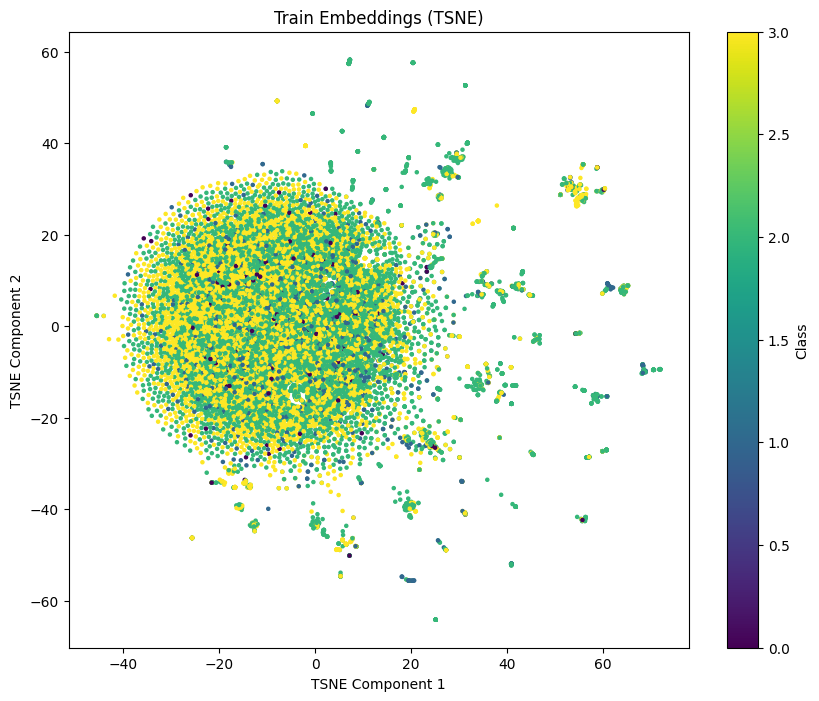

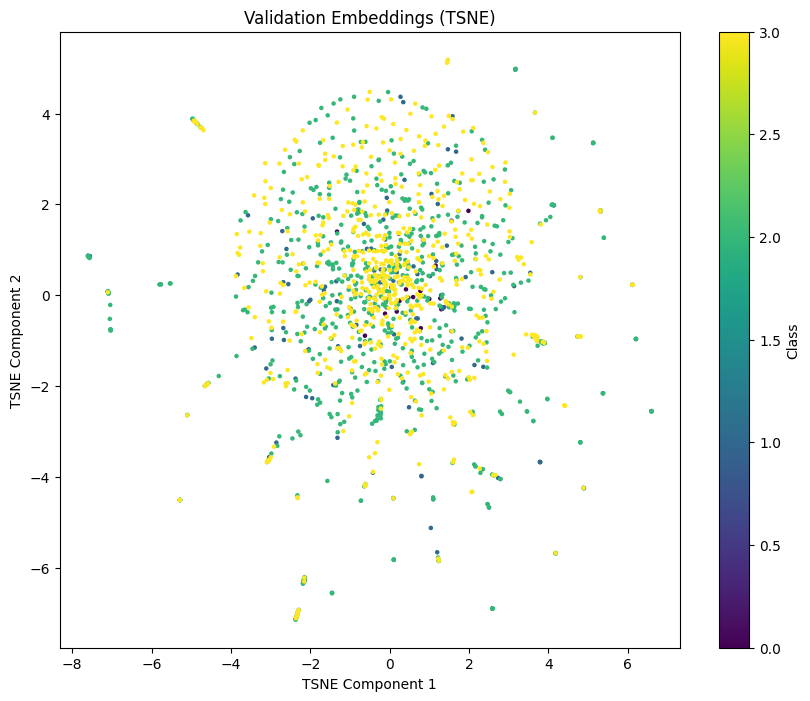

In [ ]:
# Function to extract embeddings
def extract_embeddings(model, loader, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)

            # Extract embeddings
            features = model.conv_layers(images)
            features = features.view(features.size(0), -1)
            embeddings.append(features.cpu().numpy())
            labels.append(targets.cpu().numpy())
    
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
    return embeddings, labels

# Extract embeddings
train_embeddings, train_labels = extract_embeddings(model, train_loader, device)
val_embeddings, val_labels = extract_embeddings(model, val_loader, device)

# Visualization with TSNE
def visualize_embeddings(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', s=5)
    plt.colorbar(scatter, label="Class")
    plt.title(title)
    plt.xlabel("TSNE Component 1")
    plt.ylabel("TSNE Component 2")
    plt.show()

# Visualize training embeddings
visualize_embeddings(train_embeddings, train_labels, "Train Embeddings (TSNE)")

# Visualize validation embeddings
visualize_embeddings(val_embeddings, val_labels, "Validation Embeddings (TSNE)")


In [7]:
# Загружаем предобученную модель
pretrained_model = resnet18(pretrained=True)

# Замораживаем веса backbone
for param in pretrained_model.parameters():
    param.requires_grad = False

# Добавляем кастомный классификатор
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, len(categories))
)
pretrained_model = pretrained_model.to(device)

# Оптимизатор и функция потерь
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.fc.parameters(), lr=learning_rate)

# Обучение модели Transfer Learning
train_model(pretrained_model, train_loader, val_loader, criterion, optimizer, num_epochs)


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Acer/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:37<00:00, 1.24MB/s]


Epoch [1/30]
Train Loss: 0.9248, Accuracy: 56.10%
Val Loss: 0.8989, Accuracy: 56.39%
Epoch [2/30]
Train Loss: 0.8881, Accuracy: 58.01%
Val Loss: 0.8784, Accuracy: 59.05%
Epoch [3/30]
Train Loss: 0.8690, Accuracy: 59.37%
Val Loss: 0.8896, Accuracy: 58.06%
Epoch [4/30]
Train Loss: 0.8646, Accuracy: 59.73%
Val Loss: 0.8725, Accuracy: 58.85%
Epoch [5/30]
Train Loss: 0.8587, Accuracy: 59.54%
Val Loss: 0.8706, Accuracy: 58.39%
Epoch [6/30]
Train Loss: 0.8500, Accuracy: 60.37%
Val Loss: 0.8628, Accuracy: 58.32%
Epoch [7/30]
Train Loss: 0.8458, Accuracy: 60.29%
Val Loss: 0.8709, Accuracy: 56.99%
Epoch [8/30]
Train Loss: 0.8422, Accuracy: 60.43%
Val Loss: 0.8699, Accuracy: 56.66%
Epoch [9/30]
Train Loss: 0.8364, Accuracy: 60.94%
Val Loss: 0.8545, Accuracy: 59.45%
Epoch [10/30]
Train Loss: 0.8333, Accuracy: 61.26%
Val Loss: 0.8637, Accuracy: 58.39%
Epoch [11/30]
Train Loss: 0.8295, Accuracy: 60.62%
Val Loss: 0.8831, Accuracy: 58.19%
Epoch [12/30]
Train Loss: 0.8217, Accuracy: 61.53%
Val Loss: 0.

In [ ]:
import time

# Измерение времени обучения для CNN
start_time = time.time()
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)
cnn_time = time.time() - start_time

# Измерение времени обучения для Transfer Learning
start_time = time.time()
train_model(pretrained_model, train_loader, val_loader, criterion, optimizer, num_epochs)
transfer_time = time.time() - start_time

print(f"Simple CNN training time: {cnn_time:.2f} seconds")
print(f"Transfer Learning training time: {transfer_time:.2f} seconds")
